In [1]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
dowhy.__version__

'0.8'

## Generate the datasets

In [93]:
# Define the sample size
sample_size = 1000

# The first dataset
W = np.random.randn(sample_size)
X = 0.3*W + np.random.randn(sample_size)
Y = 0.45*W + 0.87*X + 0.4*np.random.randn(sample_size)

# Note that we pass all the variables to the dataframe
data_1 = pd.DataFrame(np.vstack([X, W, Y]).T, columns=['X', 'W', 'Y'])


# The second dataset
U = np.random.randn(sample_size)
X = 0.3*U + np.random.randn(sample_size)
Z = 0.78*X + 0.3*np.random.randn(sample_size)
Y = 0.45*U + 0.87*Z + 0.4*np.random.randn(sample_size)

# Note that we're ommiting U in the dataframe as it's unobserved
data_2 = pd.DataFrame(np.vstack([X, Z, Y]).T, columns=['X', 'Z', 'Y']) 


# The third dataset
U = np.random.randn(sample_size)
Z = np.random.randn(sample_size)
X = 0.6*Z + 0.43*U + np.random.randn(sample_size)
Y = 0.45*U + 0.87*X + 0.4*np.random.randn(sample_size)

# Note that we're ommiting U in the dataframe as it's unobserved
data_3 = pd.DataFrame(np.vstack([X, Z, Y]).T, columns=['X', 'Z', 'Y'])

## Dataset 1

### Step 1: Model the problem

In [94]:
# Create the graph
graph_1 = """
    graph [
    
        directed 1

        node [id "X" label "X"]    
        node [id "W" label "W"]
        node [id "Y" label "Y"]
        
        edge [source "W" target "X"]
        edge [source "W" target "Y"]
        edge [source "X" target "Y"]
    ]    
"""

In [95]:
# Instantiate the CausalModel object
model_1 = CausalModel(
    data=data_1,
    treatment='X',
    outcome='Y',
    graph=graph_1
)

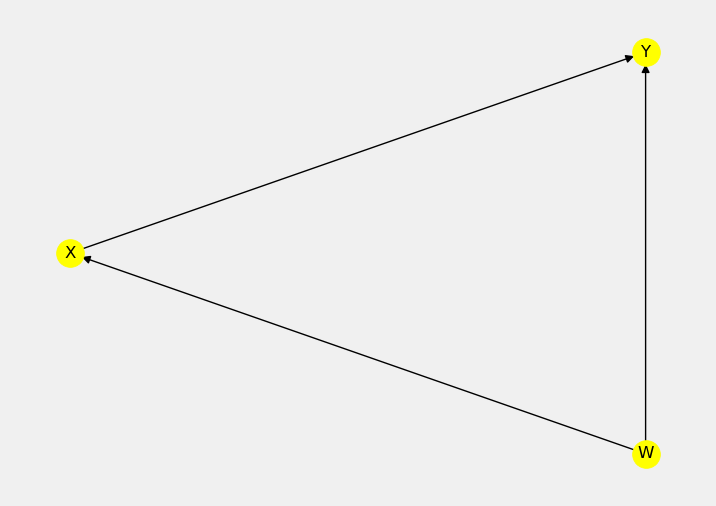

In [96]:
model_1.view_model()

### Step 2: Identify the estimand

In [97]:
estimand_1 = model_1.identify_effect()
print(f'MODEL 2:\n{estimand_1}')

MODEL 2:
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|W])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,W,U) = P(Y|X,W)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Step 3: Estimate the effect

In [98]:
estimate_1 = model_1.estimate_effect(
    identified_estimand=estimand_1,
    method_name='backdoor.linear_regression')

print(f'Estimate of causal effect (MODEL 1): {estimate_1.value}')

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
Estimate of causal effect (MODEL 1): 0.8591823936185948


## Dataset 2


Graph for Model 2:
graph [directed 1
	node [id "X" label "X"]
	node [id "Y" label "Y"]
	node [id "Z" label "Z"]
	node [id "U" label "U"]
	edge [source "X" target "Z"]
	edge [source "Z" target "Y"]
	edge [source "U" target "X"]
	edge [source "U" target "Y"]
]

Estimand for Model 2:
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)

two_stage_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confiden

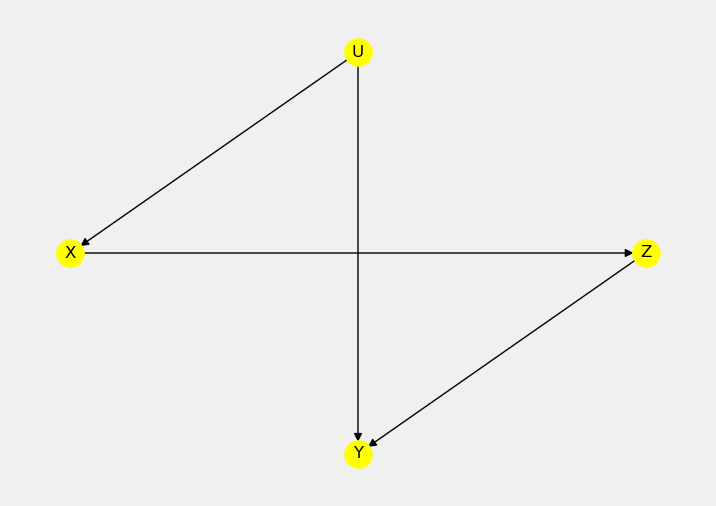

In [99]:
# STEP 1

nodes_2 = ['X', 'Y', 'Z', 'U']
edges_2 = ['XZ', 'ZY', 'UX', 'UY']

# Generate the GML graph
graph_2 = 'graph [directed 1\n'

for node in nodes_2:
    graph_2 += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges_2:
    graph_2 += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
graph_2 += ']'

# Print out the graph
print(f'\nGraph for Model 2:\n{graph_2}\n')

# Instantiate the model
model_2 = CausalModel(
    data=data_2,
    treatment='X',
    outcome='Y',
    graph=graph_2,  
)

model_2.view_model()


# STEP 2
estimand_2 = model_2.identify_effect()
print(f'Estimand for Model 2:\n{estimand_2}')


# STEP 3
estimate_2 = model_2.estimate_effect(
    identified_estimand=estimand_2,
    method_name='frontdoor.two_stage_regression')

print(f'\n\nEstimate of causal effect (Model 2): {estimate_2.value}')

## Dataset 3 - Instrumental Variable


Graph for Model 3:
graph [directed 1
	node [id "X" label "X"]
	node [id "Y" label "Y"]
	node [id "Z" label "Z"]
	node [id "U" label "U"]
	edge [source "Z" target "X"]
	edge [source "U" target "X"]
	edge [source "U" target "Y"]
	edge [source "X" target "Y"]
]

Estimand for Model 2:
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([X])⎟  ⎥
 ⎣d[Z]    ⎝d[Z]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{X}, then ¬({Z}→Y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

instrumental_variable


Estimate of causal effect (Model 3): 0.9033910718128734


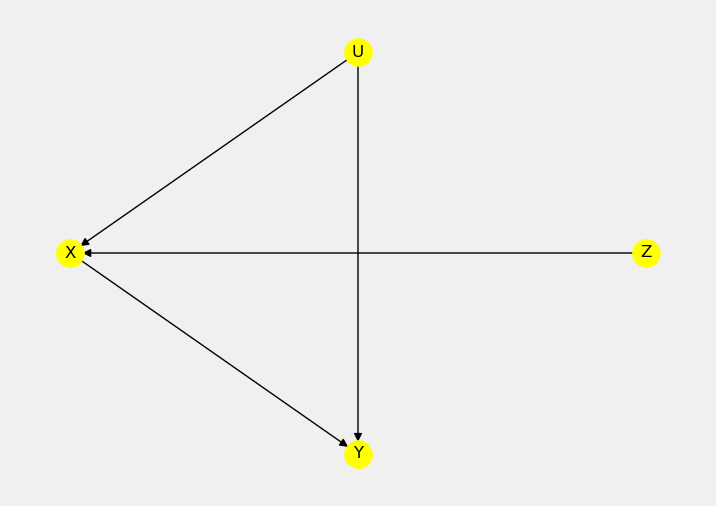

In [100]:
# STEP 1

nodes_3 = ['X', 'Y', 'Z', 'U']
edges_3 = ['ZX', 'UX', 'UY', 'XY']

# Generate the GML graph
graph_3 = 'graph [directed 1\n'

for node in nodes_3:
    graph_3 += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges_3:
    graph_3 += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
graph_3 += ']'

# Print out the graph
print(f'\nGraph for Model 3:\n{graph_3}\n')

# Instantiate the model
model_3 = CausalModel(
    data=data_3,
    treatment='X',
    outcome='Y',
    graph=graph_3,  
)

model_3.view_model()


# STEP 2
estimand_3 = model_3.identify_effect()
print(f'Estimand for Model 2:\n{estimand_3}')


# STEP 3
estimate_3 = model_3.estimate_effect(
    identified_estimand=estimand_3,
    method_name='iv.instrumental_variable')

print(f'\n\nEstimate of causal effect (Model 3): {estimate_3.value}')

In [ ]:
# Estimand for Model 2:
# Estimand type: nonparametric-ate

# ### Estimand : 1
# Estimand name: backdoor
# No such variable(s) found!

# ### Estimand : 2
# Estimand name: iv
# Estimand expression:
#  ⎡                   -1⎤
#  ⎢ d      ⎛ d       ⎞  ⎥
# E⎢────(Y)⋅⎜────([X])⎟  ⎥
#  ⎣d[Z]    ⎝d[Z]     ⎠  ⎦
# Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z})
# Estimand assumption 2, Exclusion: If we remove {Z}→{X}, then ¬({Z}→Y)

# ### Estimand : 3
# Estimand name: frontdoor
# No such variable(s) found!